# ICE Training Data Extraction Experiment

In [1]:
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import logging
from tqdm.notebook import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
logging.basicConfig()

logger = logging.getLogger('xai-privacy')

from experiment_setup import run_all_experiments
from experiment_setup import get_heart_disease_dataset
from experiment_setup import get_census_dataset
from experiment_setup import TrainingDataExtraction

In [3]:
DATASET_HALF = True

data_heart_dict, data_heart_num_dict, data_heart_cat_dict = get_heart_disease_dataset(halve_dataset=DATASET_HALF)
data_census_dict, data_census_num_dict, data_census_cat_dict = get_census_dataset(halve_dataset=DATASET_HALF)

data_heart = data_heart_dict['dataset']
data_heart_num = data_heart_num_dict['dataset']
data_heart_cat = data_heart_cat_dict['dataset']
outcome_name_heart = data_heart_dict['outcome']
numeric_features_heart = data_heart_dict['num']

Feature Age: removed 0 rows for missing values.
Feature RestingBP: removed 59 rows for missing values.
Feature Cholesterol: removed 27 rows for missing values.
Feature FastingBS: add unknown category 2.0
Feature RestingECG: add unknown category 3.0
Feature MaxHR: removed 0 rows for missing values.
Feature Oldpeak: removed 7 rows for missing values.
Feature ST_Slope: add unknown category 4.0
Feature CA: add unknown category 4.0
Feature Thal: add unknown category 8.0
Dropped 71 of 548
Dropped 72 of 548
Dropped 71 of 548
Dropped: 2399 of 32561
census: Dropped 1256 of 15081
num: Dropped 8827 of 15081
cat: Dropped 4850 of 15081


This notebook will go through the experiment for training data extraction with individual conditional expectation (ICE). The experiments will be performed without attacker access to the model. Training data extraction means an attacker can find out the feature values of samples from the training data without prior knowledge of them. The attacker only has access to the explanation.

The idea for ICE training data extraction is as follows: The attacker can check which predictions values are the same for different ICE lines from the same training sample (each training sample has one ICE line for every feature). If there is only one possible combination of feature values with the same prediction value, then these feature values must make up the original sample. If multiple possibilites exist, then an unambiguous extraction is impossible (without access to the model). In this case the sample cannot be extracted by the attacker.

First, we implement the `train_explainer` and `training_data_extraction_no_model_access` functions:

In [4]:
class ICETDE(TrainingDataExtraction):
    def train_explainer(self, data_train, model):
        # Calculate ICE
        ice_features = []

        x_train = data_train.drop(self.outcome_name, axis=1)
        num_samples = len(x_train)
        
        for i in range(self.features.shape[1]):
            # training data extraction needs the ICE plots to be complete. Every possible feature value needs to be evaluated. Therefore,
            # we set the grid resolution one higher than the number of samples.
            ice_features.append(partial_dependence(estimator=model, X=x_train, features=[i], percentiles=(0,1),\
                                                   grid_resolution=num_samples + 1, kind='individual'))
            
        return ice_features
        
    @staticmethod
    def training_data_extraction_no_model_access(explainer, num_queries, feature_formats, rng):
        # Get all feature names
        feature_names = []
        
        for feature in feature_formats:
            feature_names.append(feature['name'])
            
        # better parameter name
        ice_features = explainer
        
        # Collect all extracted samples in this list
        extracted_samples = []

        # Get proper number of extractions to attempt based on input.
        if num_queries is None:
            index_range = len(ice_features[0]['individual'][0])
        else:
            index_range = num_queries

        # Attempt extraction for each sample until index_range
        for sample_index in tqdm(range(index_range)):

            num_of_features = len(ice_features)

            # Create array that contains all predictions values that are shared across all ICE lines for this sample.
            shared_preds = ice_features[0]['individual'][0][sample_index]
            for i in range(num_of_features):
                shared_preds = np.intersect1d(shared_preds, ice_features[i]['individual'][0][sample_index])

            # If the lines share no prediction values then they cannot be part of the same sample (they must at least share
            # one prediction value: the original prediction value of the sample).
            if len(shared_preds) == 0:
                logger.debug(f'Sample index {sample_index}: No extraction possible: There are no shared prediction values.')
                continue

            # If the lines share multiple prediction values then the attacker cannot be sure which one belongs to the original 
            # sample. Extraction is aborted because it is not possible to extract a single definite sample.
            if len(shared_preds) > 1:
                logger.debug(f'Sample index {sample_index}: Unambiguous extraction impossible: Multiple shared prediction values: {shared_preds}')
                continue

            logger.debug(f'Sample index {sample_index}: Shared prediction value: {shared_preds[0]}')

            # This array will contain the feature values where the shared prediction value occurs. This the extracted sample.
            extracted_sample = np.zeros(num_of_features)

            # This boolean tracks whether an unambiguous extraction is still possible. It becomes False if there are multiple
            # feature values for one feature for the shared prediction value. In that case, no unambiguous extraction is possible
            # anymore.
            unambiguous_extraction_possible = True

            for i in range(num_of_features):

                # Get indices where the ICE lines prediction is equal to the shared prediction.
                indices = np.where(ice_features[i]['individual'][0][sample_index] == shared_preds[0])[0]

                # If multiple feature values for one feature with the shared prediction value occur, then unamiguous extraction
                # is no longer possible. Abort the extraction process for this sample.
                if len(indices) > 1:
                    unambiguous_extraction_possible = False
                    break

                # Get the feature value for index with shared prediction value and add it to the extracted sample.
                values = ice_features[i]['values'][0][indices]
                extracted_sample[i] = values[0]

            # Abort extraction process if unambiguous extraction is not possible
            if not unambiguous_extraction_possible:
                logger.debug("Sample index %s: Unambiguous extraction impossible (multiple values for shared prediction)." \
                              % (sample_index))
                continue

            extracted_samples.append(extracted_sample)

            logger.debug(f'Sample index {sample_index}: Extracted sample: {extracted_sample}')

        extracted_samples_df = pd.DataFrame(extracted_samples, columns=feature_names)
            
        # Return all extracted samples
        return extracted_samples_df

# Dataset 1: Heart Disease (numeric)

Before running the experiment, we we will have a short look at the visual explanation of ICE. The underlying data of these graphs will be our attack vector for training data extraction.

The dark blue lines represent the average change in predictions for a change in the specified feature. The light blue lines are the change in prediction for single samples from the training data. These are the ICE lines for individual samples from the training data.

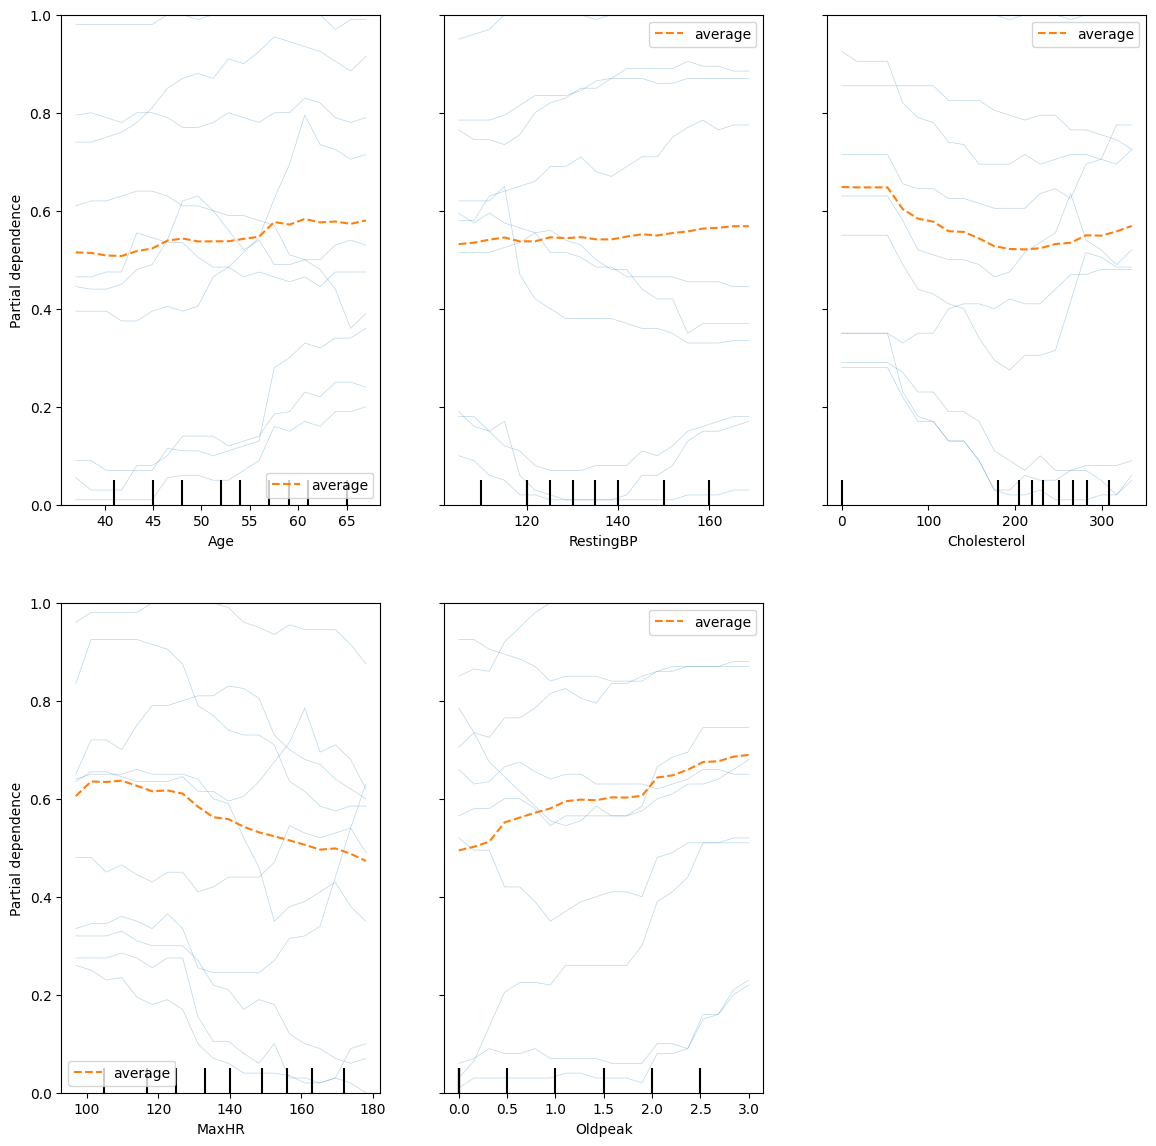

In [5]:
# Train a random forest on training data.
features = data_heart.drop(outcome_name_heart, axis=1)
labels = data_heart[outcome_name_heart]

model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

num_of_features = 8

fig, ax = plt.subplots(figsize=(14, 14))

display = PartialDependenceDisplay.from_estimator(
       model, features, numeric_features_heart, kind="both", subsample=10,
       n_jobs=3, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

As a proof of concept for our privacy attack, we run the experiment for a few iterations with logging to show how the training data extraction function works in principle.

In [6]:
logger.setLevel(logging.DEBUG)

EXP = ICETDE(data_heart, numeric_features_heart, outcome_name_heart, random_state=0)
EXP.training_data_extraction_experiment(num_queries=10, model=MLPClassifier(random_state=0), model_access=False)

logger.setLevel(logging.INFO)

DEBUG:xai-privacy:Numeric Features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
DEBUG:xai-privacy:Categorical Features: ['CA', 'ChestPainType', 'ExerciseAngina', 'FastingBS', 'RestingECG', 'ST_Slope', 'Sex', 'Thal']
c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:xai-privacy:Sample index 0: Shared prediction value: 0.9963223482430343
DEBUG:xai-privacy:Sample index 0: Extracted sample: [ 55.    0.    4.  180.  327.    0.    1.  117.    1.    3.4   2.    0.
   3. ]
DEBUG:xai-privacy:Sample index 1: Shared prediction value: 0.0141335350168537
DEBUG:xai-privacy:Sample index 1: Extracted sample: [ 44.   1.   2. 130. 219.   0.   2. 188.   0.   0.   1.   0.   3.]
DEBUG:xai-privacy:Sample index 2: Shared prediction value: 0.009469768443598389
DEBUG:xai-privacy:Sample index 2: Extracted sample: [ 44.   1.   2. 120. 220.   0.   0. 170.   0.   0.   1.   0.   3.]
DEBUG:xai-privacy:Sample index 3: Shared prediction value: 0.9998069674115502
DEBUG:xai-privacy:Sample index 3: Extracted sample: [ 51.    1.    4.   95.    0.    2.    0.  126.    0.    2.2   2.    4.
   8. ]
DEBUG:xai-privacy:Sample index 4: Shared prediction value: 0.9055440560983494
DEBUG:xai-privacy:Sample index 4: Extracted sample: [ 69.   1.   4. 135.   0.   0.   0. 130.   0.   0.   2

Total time: 4.80s (training model: 1.22s, training explainer: 3.51s, experiment: 0.07s)
Number of extracted samples: 10
Number of accurate extracted samples: 10
Precision: 1.0, recall: 1.0


The proof of concept shows that training data extraction with ICE can be highly accurate and complete (recall 100%).

Now we begin executing the actual experiment. We begin by defining the table that will hold the results for all our different experiment variations. Then we execute all variations of the experiment for this dataset. We vary the model between a decision tree, a random forest and a neural network. Each model uses the default configuration of scikit-learn.

In [7]:
dataset_dicts = [data_heart_dict, data_heart_num_dict, data_heart_cat_dict, data_census_dict, data_census_num_dict, data_census_cat_dict]

dt_dict = {'name': 'decision tree', 'model': DecisionTreeClassifier}
rf_dict = {'name': 'random forest', 'model': es.RandomForestClassifier}
nn_dict = {'name': 'neural network', 'model': MLPClassifier}

model_dicts = [dt_dict, rf_dict, nn_dict]

In [8]:
# This will run the experiment for each dataset and model combination

results = run_all_experiments(ICETDE, dataset_dicts, model_dicts, random_state=0, num_queries=None, model_access=False, threads=1, is_mem_inf=False, repeat=10)

dataset: heart, model: decision tree (repetition 0)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.65s (training model: 0.01s, training explainer: 2.43s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 1)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.55s (training model: 0.01s, training explainer: 2.32s, experiment: 0.22s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 2)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.58s (training model: 0.02s, training explainer: 2.37s, experiment: 0.19s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 3)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.09s (training model: 0.02s, training explainer: 2.83s, experiment: 0.23s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 4)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.62s (training model: 0.01s, training explainer: 2.41s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 5)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.98s (training model: 0.02s, training explainer: 2.76s, experiment: 0.21s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 6)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.43s (training model: 0.02s, training explainer: 2.23s, experiment: 0.18s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 7)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.49s (training model: 0.02s, training explainer: 2.26s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 8)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.41s (training model: 0.02s, training explainer: 2.19s, experiment: 0.21s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: decision tree (repetition 9)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.55s (training model: 0.01s, training explainer: 2.34s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 0)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.48s (training model: 0.05s, training explainer: 3.25s, experiment: 0.19s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 1)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.46s (training model: 0.05s, training explainer: 3.21s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 2)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.45s (training model: 0.04s, training explainer: 3.21s, experiment: 0.19s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 3)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.64s (training model: 0.04s, training explainer: 3.41s, experiment: 0.19s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 4)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.49s (training model: 0.05s, training explainer: 3.25s, experiment: 0.19s)
Number of extracted samples: 1
Number of accurate extracted samples: 1
Precision: 1.0, recall: 0.0020964360587002098
dataset: heart, model: random forest (repetition 5)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.59s (training model: 0.04s, training explainer: 3.31s, experiment: 0.24s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 6)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.50s (training model: 0.05s, training explainer: 3.25s, experiment: 0.20s)
Number of extracted samples: 1
Number of accurate extracted samples: 1
Precision: 1.0, recall: 0.0020964360587002098
dataset: heart, model: random forest (repetition 7)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.49s (training model: 0.05s, training explainer: 3.24s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 8)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.43s (training model: 0.04s, training explainer: 3.21s, experiment: 0.18s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest (repetition 9)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 3.49s (training model: 0.05s, training explainer: 3.25s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.62s (training model: 0.95s, training explainer: 3.25s, experiment: 0.41s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.68s (training model: 0.93s, training explainer: 3.30s, experiment: 0.45s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.67s (training model: 0.92s, training explainer: 3.32s, experiment: 0.43s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.45s (training model: 0.84s, training explainer: 3.16s, experiment: 0.45s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.63s (training model: 0.91s, training explainer: 3.28s, experiment: 0.44s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.72s (training model: 0.96s, training explainer: 3.28s, experiment: 0.48s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.69s (training model: 0.95s, training explainer: 3.30s, experiment: 0.43s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.56s (training model: 0.95s, training explainer: 3.17s, experiment: 0.43s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.69s (training model: 0.95s, training explainer: 3.30s, experiment: 0.44s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 4.99s (training model: 1.17s, training explainer: 3.36s, experiment: 0.46s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 0)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.03s (training model: 0.00s, training explainer: 0.92s, experiment: 0.11s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 1)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.03s (training model: 0.01s, training explainer: 0.92s, experiment: 0.10s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 2)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.05s (training model: 0.01s, training explainer: 0.92s, experiment: 0.12s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 3)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.09s (training model: 0.01s, training explainer: 0.95s, experiment: 0.13s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 4)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.06s (training model: 0.00s, training explainer: 0.94s, experiment: 0.12s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 5)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.09s (training model: 0.01s, training explainer: 0.96s, experiment: 0.12s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 6)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.07s (training model: 0.00s, training explainer: 0.96s, experiment: 0.12s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 7)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.07s (training model: 0.01s, training explainer: 0.94s, experiment: 0.12s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 8)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.09s (training model: 0.00s, training explainer: 0.97s, experiment: 0.12s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: decision tree (repetition 9)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 1.06s (training model: 0.01s, training explainer: 0.95s, experiment: 0.10s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: random forest (repetition 0)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.13s (training model: 0.05s, training explainer: 1.94s, experiment: 0.14s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.0063025210084033615
dataset: heart numeric, model: random forest (repetition 1)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.11s (training model: 0.03s, training explainer: 1.95s, experiment: 0.13s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.0063025210084033615
dataset: heart numeric, model: random forest (repetition 2)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.11s (training model: 0.03s, training explainer: 1.92s, experiment: 0.16s)
Number of extracted samples: 4
Number of accurate extracted samples: 4
Precision: 1.0, recall: 0.008403361344537815
dataset: heart numeric, model: random forest (repetition 3)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.18s (training model: 0.03s, training explainer: 1.99s, experiment: 0.15s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.012605042016806723
dataset: heart numeric, model: random forest (repetition 4)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.09s (training model: 0.05s, training explainer: 1.91s, experiment: 0.13s)
Number of extracted samples: 5
Number of accurate extracted samples: 5
Precision: 1.0, recall: 0.01050420168067227
dataset: heart numeric, model: random forest (repetition 5)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.20s (training model: 0.03s, training explainer: 2.00s, experiment: 0.17s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.012605042016806723
dataset: heart numeric, model: random forest (repetition 6)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.12s (training model: 0.03s, training explainer: 1.93s, experiment: 0.15s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.012605042016806723
dataset: heart numeric, model: random forest (repetition 7)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.11s (training model: 0.04s, training explainer: 1.92s, experiment: 0.15s)
Number of extracted samples: 4
Number of accurate extracted samples: 4
Precision: 1.0, recall: 0.008403361344537815
dataset: heart numeric, model: random forest (repetition 8)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.09s (training model: 0.04s, training explainer: 1.91s, experiment: 0.14s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.0063025210084033615
dataset: heart numeric, model: random forest (repetition 9)


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.18s (training model: 0.04s, training explainer: 2.00s, experiment: 0.15s)
Number of extracted samples: 9
Number of accurate extracted samples: 9
Precision: 1.0, recall: 0.018907563025210083
dataset: heart numeric, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.51s (training model: 0.68s, training explainer: 1.56s, experiment: 0.28s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.56s (training model: 0.67s, training explainer: 1.61s, experiment: 0.28s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.53s (training model: 0.67s, training explainer: 1.58s, experiment: 0.28s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.59s (training model: 0.72s, training explainer: 1.59s, experiment: 0.28s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.49s (training model: 0.65s, training explainer: 1.55s, experiment: 0.30s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.50s (training model: 0.67s, training explainer: 1.52s, experiment: 0.31s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.56s (training model: 0.66s, training explainer: 1.61s, experiment: 0.29s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.57s (training model: 0.72s, training explainer: 1.57s, experiment: 0.28s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.54s (training model: 0.69s, training explainer: 1.56s, experiment: 0.29s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/476 [00:00<?, ?it/s]

Total time: 2.55s (training model: 0.70s, training explainer: 1.53s, experiment: 0.31s)
Number of extracted samples: 476
Number of accurate extracted samples: 476
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 0)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.69s (training model: 0.00s, training explainer: 0.43s, experiment: 0.26s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 1)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.61s (training model: 0.01s, training explainer: 0.40s, experiment: 0.19s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 2)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.59s (training model: 0.01s, training explainer: 0.38s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 3)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.57s (training model: 0.01s, training explainer: 0.36s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 4)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.58s (training model: 0.01s, training explainer: 0.37s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 5)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.63s (training model: 0.01s, training explainer: 0.39s, experiment: 0.23s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 6)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.56s (training model: 0.01s, training explainer: 0.37s, experiment: 0.18s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 7)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.64s (training model: 0.02s, training explainer: 0.43s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 8)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.59s (training model: 0.01s, training explainer: 0.36s, experiment: 0.22s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: decision tree (repetition 9)


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 0.58s (training model: 0.02s, training explainer: 0.36s, experiment: 0.20s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: random forest (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.78s (training model: 0.18s, training explainer: 1.38s, experiment: 0.22s)
Number of extracted samples: 59
Number of accurate extracted samples: 59
Precision: 1.0, recall: 0.12368972746331237
dataset: heart categorical, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.88s (training model: 0.20s, training explainer: 1.40s, experiment: 0.27s)
Number of extracted samples: 57
Number of accurate extracted samples: 57
Precision: 1.0, recall: 0.11949685534591195
dataset: heart categorical, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.83s (training model: 0.17s, training explainer: 1.39s, experiment: 0.26s)
Number of extracted samples: 69
Number of accurate extracted samples: 69
Precision: 1.0, recall: 0.14465408805031446
dataset: heart categorical, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.84s (training model: 0.18s, training explainer: 1.42s, experiment: 0.24s)
Number of extracted samples: 63
Number of accurate extracted samples: 63
Precision: 1.0, recall: 0.1320754716981132
dataset: heart categorical, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.88s (training model: 0.19s, training explainer: 1.41s, experiment: 0.28s)
Number of extracted samples: 62
Number of accurate extracted samples: 62
Precision: 1.0, recall: 0.129979035639413
dataset: heart categorical, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.85s (training model: 0.21s, training explainer: 1.39s, experiment: 0.25s)
Number of extracted samples: 59
Number of accurate extracted samples: 59
Precision: 1.0, recall: 0.12368972746331237
dataset: heart categorical, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.94s (training model: 0.18s, training explainer: 1.50s, experiment: 0.26s)
Number of extracted samples: 64
Number of accurate extracted samples: 64
Precision: 1.0, recall: 0.13417190775681342
dataset: heart categorical, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.98s (training model: 0.17s, training explainer: 1.57s, experiment: 0.24s)
Number of extracted samples: 63
Number of accurate extracted samples: 63
Precision: 1.0, recall: 0.1320754716981132
dataset: heart categorical, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.77s (training model: 0.17s, training explainer: 1.36s, experiment: 0.24s)
Number of extracted samples: 62
Number of accurate extracted samples: 62
Precision: 1.0, recall: 0.129979035639413
dataset: heart categorical, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 1.80s (training model: 0.18s, training explainer: 1.38s, experiment: 0.24s)
Number of extracted samples: 65
Number of accurate extracted samples: 65
Precision: 1.0, recall: 0.13626834381551362
dataset: heart categorical, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.02s (training model: 1.11s, training explainer: 0.50s, experiment: 0.41s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.21s (training model: 1.25s, training explainer: 0.50s, experiment: 0.45s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.08s (training model: 1.13s, training explainer: 0.50s, experiment: 0.46s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.04s (training model: 1.12s, training explainer: 0.48s, experiment: 0.44s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.00s (training model: 1.09s, training explainer: 0.50s, experiment: 0.42s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.06s (training model: 1.23s, training explainer: 0.46s, experiment: 0.37s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.19s (training model: 1.20s, training explainer: 0.56s, experiment: 0.43s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.36s (training model: 1.22s, training explainer: 0.60s, experiment: 0.54s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.19s (training model: 1.26s, training explainer: 0.50s, experiment: 0.43s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/477 [00:00<?, ?it/s]

Total time: 2.01s (training model: 1.09s, training explainer: 0.48s, experiment: 0.44s)
Number of extracted samples: 477
Number of accurate extracted samples: 477
Precision: 1.0, recall: 1.0
dataset: census, model: decision tree (repetition 0)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 14.06s (training model: 0.42s, training explainer: 8.78s, experiment: 4.86s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 1)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.91s (training model: 0.41s, training explainer: 8.58s, experiment: 4.92s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 2)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.56s (training model: 0.42s, training explainer: 8.23s, experiment: 4.91s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 3)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.61s (training model: 0.42s, training explainer: 8.37s, experiment: 4.82s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 4)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.57s (training model: 0.41s, training explainer: 8.18s, experiment: 4.98s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 5)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.71s (training model: 0.42s, training explainer: 8.35s, experiment: 4.95s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 6)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 14.05s (training model: 0.44s, training explainer: 8.48s, experiment: 5.14s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 7)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.58s (training model: 0.41s, training explainer: 8.35s, experiment: 4.82s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 8)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.57s (training model: 0.43s, training explainer: 8.29s, experiment: 4.85s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: decision tree (repetition 9)


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 13.81s (training model: 0.43s, training explainer: 8.42s, experiment: 4.96s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: random forest (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.17s (training model: 7.91s, training explainer: 105.96s, experiment: 5.30s)
Number of extracted samples: 2
Number of accurate extracted samples: 2
Precision: 1.0, recall: 0.00014466546112115733
dataset: census, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.34s (training model: 7.89s, training explainer: 106.36s, experiment: 5.10s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.00043399638336347196
dataset: census, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 118.43s (training model: 7.89s, training explainer: 105.33s, experiment: 5.21s)
Number of extracted samples: 1
Number of accurate extracted samples: 1
Precision: 1.0, recall: 7.233273056057866e-05
dataset: census, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.03s (training model: 7.98s, training explainer: 105.89s, experiment: 5.16s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.00043399638336347196
dataset: census, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.52s (training model: 8.05s, training explainer: 106.12s, experiment: 5.34s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.00021699819168173598
dataset: census, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.63s (training model: 7.97s, training explainer: 106.32s, experiment: 5.33s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.00021699819168173598
dataset: census, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.93s (training model: 7.93s, training explainer: 106.81s, experiment: 5.19s)
Number of extracted samples: 2
Number of accurate extracted samples: 2
Precision: 1.0, recall: 0.00014466546112115733
dataset: census, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.32s (training model: 7.94s, training explainer: 106.10s, experiment: 5.28s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.00043399638336347196
dataset: census, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 119.63s (training model: 7.99s, training explainer: 106.30s, experiment: 5.34s)
Number of extracted samples: 6
Number of accurate extracted samples: 6
Precision: 1.0, recall: 0.00043399638336347196
dataset: census, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 120.11s (training model: 7.93s, training explainer: 106.99s, experiment: 5.19s)
Number of extracted samples: 4
Number of accurate extracted samples: 4
Precision: 1.0, recall: 0.00028933092224231466
dataset: census, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.97s (training model: 30.76s, training explainer: 17.25s, experiment: 31.96s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.45s (training model: 30.70s, training explainer: 17.21s, experiment: 31.54s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.52s (training model: 30.91s, training explainer: 17.11s, experiment: 31.50s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.33s (training model: 30.72s, training explainer: 17.12s, experiment: 31.48s)
Number of extracted samples: 13775
Number of accurate extracted samples: 13775
Precision: 1.0, recall: 0.9963833634719711
dataset: census, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.48s (training model: 30.66s, training explainer: 17.05s, experiment: 31.77s)
Number of extracted samples: 13789
Number of accurate extracted samples: 13789
Precision: 1.0, recall: 0.9973960216998191
dataset: census, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.52s (training model: 30.70s, training explainer: 17.25s, experiment: 31.57s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 81.27s (training model: 32.29s, training explainer: 17.21s, experiment: 31.77s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.40s (training model: 30.84s, training explainer: 17.13s, experiment: 31.43s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 78.97s (training model: 30.51s, training explainer: 16.95s, experiment: 31.51s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/13825 [00:00<?, ?it/s]

Total time: 79.37s (training model: 30.72s, training explainer: 16.96s, experiment: 31.69s)
Number of extracted samples: 13754
Number of accurate extracted samples: 13754
Precision: 1.0, recall: 0.994864376130199
dataset: census numeric, model: decision tree (repetition 0)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.53s (training model: 0.01s, training explainer: 1.12s, experiment: 1.40s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 1)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.63s (training model: 0.02s, training explainer: 1.26s, experiment: 1.34s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 2)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.43s (training model: 0.01s, training explainer: 1.11s, experiment: 1.30s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 3)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.53s (training model: 0.02s, training explainer: 1.13s, experiment: 1.38s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 4)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.61s (training model: 0.01s, training explainer: 1.29s, experiment: 1.32s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 5)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.63s (training model: 0.01s, training explainer: 1.27s, experiment: 1.35s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 6)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.44s (training model: 0.02s, training explainer: 1.13s, experiment: 1.29s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 7)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.42s (training model: 0.01s, training explainer: 1.14s, experiment: 1.27s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 8)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.56s (training model: 0.02s, training explainer: 1.15s, experiment: 1.39s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: decision tree (repetition 9)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 2.58s (training model: 0.02s, training explainer: 1.25s, experiment: 1.31s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: random forest (repetition 0)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 5.98s (training model: 0.10s, training explainer: 4.65s, experiment: 1.24s)
Number of extracted samples: 38
Number of accurate extracted samples: 38
Precision: 1.0, recall: 0.006076111288775184
dataset: census numeric, model: random forest (repetition 1)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.13s (training model: 0.10s, training explainer: 4.75s, experiment: 1.28s)
Number of extracted samples: 148
Number of accurate extracted samples: 148
Precision: 1.0, recall: 0.0236648544931244
dataset: census numeric, model: random forest (repetition 2)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.22s (training model: 0.07s, training explainer: 4.77s, experiment: 1.39s)
Number of extracted samples: 154
Number of accurate extracted samples: 154
Precision: 1.0, recall: 0.024624240486088904
dataset: census numeric, model: random forest (repetition 3)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.07s (training model: 0.09s, training explainer: 4.65s, experiment: 1.32s)
Number of extracted samples: 200
Number of accurate extracted samples: 200
Precision: 1.0, recall: 0.03197953309881676
dataset: census numeric, model: random forest (repetition 4)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.02s (training model: 0.09s, training explainer: 4.64s, experiment: 1.29s)
Number of extracted samples: 96
Number of accurate extracted samples: 96
Precision: 1.0, recall: 0.015350175887432043
dataset: census numeric, model: random forest (repetition 5)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 5.99s (training model: 0.10s, training explainer: 4.61s, experiment: 1.29s)
Number of extracted samples: 78
Number of accurate extracted samples: 78
Precision: 1.0, recall: 0.012472017908538535
dataset: census numeric, model: random forest (repetition 6)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.27s (training model: 0.09s, training explainer: 4.78s, experiment: 1.40s)
Number of extracted samples: 177
Number of accurate extracted samples: 177
Precision: 1.0, recall: 0.02830188679245283
dataset: census numeric, model: random forest (repetition 7)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.04s (training model: 0.10s, training explainer: 4.67s, experiment: 1.27s)
Number of extracted samples: 133
Number of accurate extracted samples: 133
Precision: 1.0, recall: 0.021266389510713142
dataset: census numeric, model: random forest (repetition 8)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.04s (training model: 0.08s, training explainer: 4.64s, experiment: 1.32s)
Number of extracted samples: 186
Number of accurate extracted samples: 186
Precision: 1.0, recall: 0.029740965781899584
dataset: census numeric, model: random forest (repetition 9)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 6.33s (training model: 0.11s, training explainer: 4.88s, experiment: 1.34s)
Number of extracted samples: 200
Number of accurate extracted samples: 200
Precision: 1.0, recall: 0.03197953309881676
dataset: census numeric, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.47s (training model: 7.66s, training explainer: 3.46s, experiment: 4.34s)
Number of extracted samples: 6253
Number of accurate extracted samples: 6253
Precision: 1.0, recall: 0.9998401023345059
dataset: census numeric, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.46s (training model: 7.62s, training explainer: 3.64s, experiment: 4.20s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.48s (training model: 7.50s, training explainer: 3.69s, experiment: 4.29s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.28s (training model: 7.47s, training explainer: 3.50s, experiment: 4.30s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.80s (training model: 7.69s, training explainer: 3.47s, experiment: 4.63s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.27s (training model: 7.58s, training explainer: 3.46s, experiment: 4.23s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 6)


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 14.39s (training model: 6.55s, training explainer: 3.52s, experiment: 4.33s)
Number of extracted samples: 6239
Number of accurate extracted samples: 6239
Precision: 1.0, recall: 0.9976015350175887
dataset: census numeric, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.22s (training model: 7.47s, training explainer: 3.47s, experiment: 4.28s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.49s (training model: 7.57s, training explainer: 3.50s, experiment: 4.42s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census numeric, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/6254 [00:00<?, ?it/s]

Total time: 15.33s (training model: 7.63s, training explainer: 3.50s, experiment: 4.20s)
Number of extracted samples: 6254
Number of accurate extracted samples: 6254
Precision: 1.0, recall: 1.0
dataset: census categorical, model: decision tree (repetition 0)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.48s (training model: 0.25s, training explainer: 1.67s, experiment: 3.56s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 1)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.50s (training model: 0.28s, training explainer: 1.61s, experiment: 3.61s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 2)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.60s (training model: 0.27s, training explainer: 1.63s, experiment: 3.70s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 3)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.49s (training model: 0.27s, training explainer: 1.63s, experiment: 3.59s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 4)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.43s (training model: 0.27s, training explainer: 1.67s, experiment: 3.49s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 5)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.67s (training model: 0.28s, training explainer: 1.69s, experiment: 3.70s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 6)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.49s (training model: 0.25s, training explainer: 1.61s, experiment: 3.63s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 7)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.55s (training model: 0.26s, training explainer: 1.70s, experiment: 3.59s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 8)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.50s (training model: 0.27s, training explainer: 1.64s, experiment: 3.59s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: decision tree (repetition 9)


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 5.52s (training model: 0.26s, training explainer: 1.67s, experiment: 3.59s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: random forest (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 33.18s (training model: 4.71s, training explainer: 22.85s, experiment: 5.62s)
Number of extracted samples: 1029
Number of accurate extracted samples: 1029
Precision: 1.0, recall: 0.1005766787215326
dataset: census categorical, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 32.87s (training model: 4.67s, training explainer: 22.80s, experiment: 5.40s)
Number of extracted samples: 987
Number of accurate extracted samples: 987
Precision: 1.0, recall: 0.09647150816147004
dataset: census categorical, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 32.93s (training model: 4.74s, training explainer: 22.87s, experiment: 5.33s)
Number of extracted samples: 990
Number of accurate extracted samples: 990
Precision: 1.0, recall: 0.09676473463004594
dataset: census categorical, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 32.97s (training model: 4.66s, training explainer: 22.74s, experiment: 5.56s)
Number of extracted samples: 1046
Number of accurate extracted samples: 1046
Precision: 1.0, recall: 0.10223829537679602
dataset: census categorical, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 32.88s (training model: 4.68s, training explainer: 22.80s, experiment: 5.40s)
Number of extracted samples: 1046
Number of accurate extracted samples: 1046
Precision: 1.0, recall: 0.10223829537679602
dataset: census categorical, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 33.40s (training model: 4.68s, training explainer: 23.22s, experiment: 5.50s)
Number of extracted samples: 1030
Number of accurate extracted samples: 1030
Precision: 1.0, recall: 0.10067442087772456
dataset: census categorical, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 33.53s (training model: 4.69s, training explainer: 23.43s, experiment: 5.41s)
Number of extracted samples: 1036
Number of accurate extracted samples: 1036
Precision: 1.0, recall: 0.10126087381487636
dataset: census categorical, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 33.25s (training model: 4.83s, training explainer: 22.95s, experiment: 5.47s)
Number of extracted samples: 1043
Number of accurate extracted samples: 1043
Precision: 1.0, recall: 0.10194506890822011
dataset: census categorical, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 33.05s (training model: 4.66s, training explainer: 22.91s, experiment: 5.48s)
Number of extracted samples: 977
Number of accurate extracted samples: 977
Precision: 1.0, recall: 0.09549408659955039
dataset: census categorical, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 33.06s (training model: 4.68s, training explainer: 22.87s, experiment: 5.51s)
Number of extracted samples: 1012
Number of accurate extracted samples: 1012
Precision: 1.0, recall: 0.09891506206626918
dataset: census categorical, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.35s (training model: 23.05s, training explainer: 3.71s, experiment: 19.59s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.63s (training model: 23.36s, training explainer: 3.68s, experiment: 19.59s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.86s (training model: 23.29s, training explainer: 3.66s, experiment: 19.91s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.75s (training model: 23.21s, training explainer: 3.72s, experiment: 19.81s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.62s (training model: 23.19s, training explainer: 3.71s, experiment: 19.72s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 48.04s (training model: 24.75s, training explainer: 3.74s, experiment: 19.55s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.47s (training model: 23.17s, training explainer: 3.63s, experiment: 19.67s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.49s (training model: 23.20s, training explainer: 3.66s, experiment: 19.63s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.57s (training model: 23.25s, training explainer: 3.71s, experiment: 19.61s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0
dataset: census categorical, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10231 [00:00<?, ?it/s]

Total time: 46.56s (training model: 23.03s, training explainer: 3.71s, experiment: 19.83s)
Number of extracted samples: 10231
Number of accurate extracted samples: 10231
Precision: 1.0, recall: 1.0


# Results

The results of all variations of the training data extraction experiment with ICE. In each experiment, sample extraction was attempted for each sample in the training data.

Precision measures the precentage of extracted samples that actually appear in the training data.

Recall measures the percentage of training samples that were succesfully extracted by the attack.

In [9]:
results

,dataset,model,repetition,accuracy,precision,recall
0,heart,decision tree,0,-1.0,NaN,0.0
1,heart,decision tree,1,-1.0,NaN,0.0
2,heart,decision tree,2,-1.0,NaN,0.0
3,heart,decision tree,3,-1.0,NaN,0.0
4,heart,decision tree,4,-1.0,NaN,0.0
...,...,...,...,...,...,...
175,census categorical,neural network,5,-1.0,1.0,1.0
176,census categorical,neural network,6,-1.0,1.0,1.0
177,census categorical,neural network,7,-1.0,1.0,1.0
178,census categorical,neural network,8,-1.0,1.0,1.0


In [10]:
file_name = 'results/2-2-ice-training-data-extraction-results'
if DATASET_HALF:
    file_name += '_dataset_size_halved'
results.to_csv(file_name + '.csv', index=False, na_rep='NaN', float_format='%.3f')

# Discussion

In our experiments, training data extraction with ICE has a recall of 0% for a decision tree, 0% to 15% for a random forest and 100% for a neural network. Since the attack cannot produce any false positive samples, precision is always 100% (when it was measureable, i.e. when any samples were extracted).

The non-existent recall of the decision tree can easily be explained by it's low number of different predictions (only 1 or 0, see discussion of experiment 1.3). This means there can never be an unambiguous extraction from ICE lines if all features have two or more possible feature values. In this situation, one of two cases must occur:

1. The ICE lines share multiple prediction values: This means no unambiguous extraction is possible.

2. They only share one common prediction value, w.l.o.g. 1. This means every line contains the prediction 1 at least once, and at least one line does not contain the prediction 0 (otherwise 0 would also be a common prediction value). This line must only contain the prediction 1 and since it has more than two feature values, it contains the prediction 1 at least at two different values. This means no unambiguous prediction is possible.

Therefore, this training data extraction attack against ICE with a decision tree always has recall 0 if all features have at least two different feature values (this is generally the case, otherwise no information would be conveyed by that feature).

While the number of unique prediction values of a random forest is much higher than a decision tree (69 vs 2, see discussion of 1.3), it is still much lower than that of a neural network (69 vs 3800, see discussion of 1.3). This explains why training data extraction has a much higher recall for a neural network than a random forest. With fewer different prediction values, it becomes more likely that multiple ICE lines have multiple common prediction values or that one prediction value occurs multiple times in an ICE line. Both events can cause the extraction to become impossible due to ambiguity.

However, how do we explain the difference in recall for a random forest between numeric data (0%) and categorical data (15%)? Let's have a look at the number of unique values per feature in the numeric dataset and the categorical dataset:

In [11]:
print('\nUnique values per column in the numeric dataset:')
for col in data_heart_num.columns:
    unique_values = data_heart_num[col].unique()
    print(f'Column {col}: {len(unique_values)}')
    
print('\nUnique values per column in the categorical dataset:')
for col in data_heart_cat.columns:
    unique_values = data_heart_cat[col].unique()
    print(f'Column {col}: {len(unique_values)}')


Unique values per column in the numeric dataset:
Column Age: 45
Column RestingBP: 55
Column Cholesterol: 180
Column MaxHR: 101
Column Oldpeak: 45
Column HeartDisease: 2

Unique values per column in the categorical dataset:
Column Age: 10
Column Sex: 2
Column ChestPainType: 4
Column RestingBP: 10
Column Cholesterol: 9
Column FastingBS: 3
Column RestingECG: 3
Column MaxHR: 10
Column ExerciseAngina: 2
Column Oldpeak: 9
Column ST_Slope: 4
Column CA: 5
Column Thal: 4
Column HeartDisease: 2


We can see that the numeric dataset generally has much more different values per feature than the categorical dataset (as one would expect). In this experiment, each ICE line was made up of the same number of points as there are different values for that feature in the training data. Therefore, if a feature has a large number of different values then its ICE lines will also contain many more values. This means it becomes more likely for one prediction value to occur multiple times and cause ambiguity in the extraction process, thereby making the extraction for that sample impossible. This explains the difference in recall between continous and categorical data well.